# Build a neural network from sractch

In [5]:
import numpy as np

https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/fc_layer.html
$$(\begin{bmatrix}
       x_{1} & x_{2} & x_{3} \end{bmatrix}.\begin{bmatrix}
       w_{11} & w_{21} \\
       w_{12} & w_{22} \\
       w_{13} & w_{23}
     \end{bmatrix})+\begin{bmatrix}
       b_{1} & b_{2}\end{bmatrix}=\begin{bmatrix}
       y_{1} & y_{2}\end{bmatrix}
$$  


$$
\frac{\partial L}{\partial X}=\begin{bmatrix}
       dout_{y1} & dout_{y2} \end{bmatrix}.\begin{bmatrix}
       w_{11} & w_{12} & w_{13} \\
       w_{21} & w_{22} & w_{23}        
     \end{bmatrix}
$$


$$
W=\begin{bmatrix}
       w_{11} & w_{12} & w_{13} \\
       w_{21} & w_{22} & w_{23}        
     \end{bmatrix} \therefore \frac{\partial L}{\partial W}=\begin{bmatrix}
       \frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{13}} \\
       \frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{23}}        
     \end{bmatrix}
$$

$$
\frac{\partial L}{\partial W}=\begin{bmatrix}
       dout_{y1} \\ dout_{y2} \end{bmatrix}.\begin{bmatrix}
       x_{1} && x_{2} && x_{3}
     \end{bmatrix}=\begin{bmatrix}
       \frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \frac{\partial L}{\partial w_{13}} \\
       \frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \frac{\partial L}{\partial w_{23}}        
     \end{bmatrix}
$$
$$
\frac{\partial L}{\partial b}=\begin{bmatrix}
       dout_{y1} & dout_{y2} \end{bmatrix}
$$


In [166]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax + b", the inputs will be x node , and the outputs 
        of this is its successors. so inputs and outputs store the connected node object

        and the value is *ax + b*
        """
        self.inputs = inputs
        self.outputs = []
        self.value = None
        self.gradients ={}
        
        for node in self.inputs:
            node.outputs.append(self) #build connected relationship
        
    def forward(self):
        """
        compute the output value based on the input nodes
        """
        raise NotImplemented
    
    def backward(self):
        """
        compute the gradients of current note based on the input nodes
        """
        raise NotImplemented


class Input(Node):
    '''
    if the node is the operator of "ax + b"; see a , b , x both as a node object
    So this Input object is for feedding data to the layer.
    In order to make graph simple ,and casue it's fully connected network ,we can see one layer as as Node
    '''
    def __init__(self, name, inputs=[]):
        self.name = name
        super().__init__(inputs)
    
    def forward(self, value= None):
        if value:         
            self.value = value
    
    def backward(self):
        self.gradients = {}
        
        #从输出节点中获取loss函数对该节点的偏导，而用该值乘该节点对input参数的导数即得到loss对input的导数
        #由此可见该节点可以得到loss对input的导数，这也是为什么该节点直接从output节点中获取loss函数对该节点的偏导
        for node in self.outputs:
            grad_cost = node.gradients[self]
            self.gradients[self] = grad_cost        
        
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)   

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        '''
        nodes, weigths,bias is Input node object
        '''
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias     
        super().__init__(inputs=[nodes, weights, bias])
        
    def forward(self):
        '''
        compute the a*x + b, In order to make it available for matric input ,
        we use numpy  to caculate    
        '''
        #print(self.x_node.value.shape, self.w_node.value.shape,'33333')
        self.value = np.dot(self.x_node.value, self.w_node.value.T) + self.b_node.value
        
    def backward(self):
        '''
        '''
        for node in self.outputs:
            grad_cost = node.gradients[self]
            self.gradients[self] = grad_cost     
            self.gradients[self.w_node] = np.dot(grad_cost.T,self.x_node.value)
            self.gradients[self.b_node] = grad_cost
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value)
            
class Sigmoid(Node):
    def __init__(self, node):
        self.x_node = node
        super().__init__([node])
    
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value   
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
            #不管是矩阵输入还是单个输入，self.partial都是一个一维常数，所以可以直接相乘
            self.gradients[self.x_node] = grad_cost * self.partial
            
class MSE(Node):
    def __init__(self,y_true, y_pre):
        self.y_true_node = y_true
        self.y_pre_node = y_pre
        super().__init__(inputs=[y_pre,y_true])
    
    def forward(self):
        y_true_flatten  = self.y_true_node.value.reshape(-1,1)
        y_pre_flatten = self.y_pre_node.value.reshape(-1,1)
        self.diff = y_true_flatten - y_pre_flatten
        self.value = np.mean(self.diff**2)
    
    def backward(self):
        n = self.y_pre_node.value.shape[0]
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_pre_node] =  (-2 / n) * self.diff

In [146]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        #print(node)
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [134]:
#单节点传播测试
#当输入数据变成矩阵时，相当于单节点就变成了layer
step1 = 3*4+2
print(step1)
step2 = 1. / (1 + np.exp(-1 * step1))
print(step2)
loss1 = (step2-0.3)**2
print(loss1)

14
0.9999991684719722
0.4899988358614525


In [135]:
x = Input('x')
y = Input('y')
w = Input('w')
b = Input('b')
linear_output = Linear(x, w, b)
yhat = Sigmoid(linear_output)
loss = MSE(y, yhat)

In [136]:
x.value = np.array([3])
y.value = np.array([0.3])
w.value = np.array([4])
b.value = np.array([2])

In [137]:
linear_output.forward()
yhat.forward()
loss.forward()

In [138]:
loss.backward()
yhat.backward()
linear_output.backward()

In [139]:
print(linear_output.value, yhat.value, loss.value)

[14] [0.99999917] 0.4899988358614525


In [140]:
def topological_sort(data_with_value):
    input_nodes = [n for n in data_with_value.keys()]
    
    nodes = input_nodes.copy()
    G = {}
    while len(nodes) > 0:
        n = nodes.pop(0) #广度优先搜索找出每个节点的in节点和out节点
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
#         if isinstance(n, Input):
#             n.value = feed_dict[n] #feed orgin value, it's ok do it somewhere else        
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L    

In [161]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    '''
    因为我们要优化的是w和b这些参数矩阵，所以trainable_nodes就应该是这些参数代表的节点
    '''
    for t in trainable_nodes:
        #print(t, t.gradients[t].shape, t.value.shape)
        step = 1 * learning_rate * t.gradients[t]
        t.value = t.value - step

In [142]:
from sklearn.datasets import load_boston

### orgin data prepare

In [17]:
data = load_boston()
X_ = data['data']
y_ = data['target']
n_features = X_.shape[1]
n_hidden_1 = 64 #定义一个隐藏层是64个节点
n_hidden_2 = 64 #定义第二隐藏层是64个节点
n_out  = 1

In [18]:
W1_, b1_ = np.random.randn(n_hidden_1, n_features), np.zeros(n_hidden_1) #这里矩阵形状要根据Linear节点里面计算方式匹配
W2_, b2_ = np.random.randn(n_hidden_2, n_features), np.zeros(n_hidden_2)
W3_, b3_ = np.random.randn(1, n_features), np.zeros(1)

In [120]:
W1_.shape

(64, 13)

### Build node 

---

In [19]:
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')
W3, b3 = Input(name='W3'), Input(name='b3')

### bulid node connected relationship

---

In [70]:
linear_output1 = Linear(X, W1, b1) # 首层网络
sigmoid_output1 = Sigmoid(linear_output1) #sigmid处理
linear_output2 = Linear(sigmoid_output1, W2, b2) #第二层
sigmoid_output2 = Sigmoid(linear_output2) ##sigmid处理
yhat = Linear(sigmoid_output2, W3, b3) #输出层
loss = MSE(y, yhat)  #最后一层，实际上这层只是用来计算loss的，在我们学习的网络层中，这层并没有，没有体现出来

In [96]:
#linear_output1.forward()

### Get topological_sort

In [71]:
input_node_with_value = {  # 
    X: X_, 
    y: y_, 
    W1: W1_, 
    W2: W2_, 
    W2: W2_,
    b1: b1_, 
    b2: b2_,
    b3: b3_}

In [101]:
graph = topological_sort(input_node_with_value) #获得拓扑排序
graph

[Input Node: b3,
 Input Node: y,
 Input Node: b1,
 Input Node: W2,
 Input Node: W1,
 Input Node: X,
 Input Node: b2,

In [73]:
def feed_data(feed_dict):
    for key in feed_dict.keys():
        key.value = feed_dict[key]

In [92]:
#feed data
feed_dict = {
    W1: W1_, 
    W2: W2_, 
    W2: W2_,
    b1: b1_, 
    b2: b2_,
    b3: b3_
}
feed_data(feed_dict)

In [ ]:
from sklearn.utils import resample

In [176]:
#def mytest():
data = load_boston()
X_ = data['data']
y_ = data['target']

X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden_1 = 64 #定义一个隐藏层是64个节点
n_hidden_2 = 64 #定义第二隐藏层是64个节点
n_out  = 1

W1_, b1_ = np.random.randn(n_hidden_1, n_features), np.zeros(n_hidden_1) #这里矩阵形状要根据Linear节点里面计算方式匹配
W2_, b2_ = np.random.randn(n_hidden_2, n_hidden_1), np.zeros(n_hidden_2)
W3_, b3_ = np.random.randn(1, n_hidden_2), np.zeros(1)

# Input data. For the training data
X, y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')
W3, b3 = Input(name='W3'), Input(name='b3')

#network connection 
linear_output1 = Linear(X, W1, b1) # 首层网络
sigmoid_output1 = Sigmoid(linear_output1) #sigmid处理
linear_output2 = Linear(sigmoid_output1, W2, b2)#第二层
sigmoid_output2 = Sigmoid(linear_output2) ##sigmid处理
yhat = Linear(sigmoid_output2, W3, b3) #输出层
loss = MSE(y, yhat)  #最后一层，实际上这层只是用来计算loss的，在我们学习的网络层中，这层并没有，没有体现出来

# get topological sort, use this order to  compute Back propagation 
input_node_with_value = {X: X_, y: y_, W1: W1_, W2: W2_, W3: W3_,b1: b1_, b2: b2_,b3: b3_}
graph = topological_sort(input_node_with_value) #获得拓扑排序

#feed initial weight and bias of each layer
feed_dict = {W1: W1_, W2: W2_, W3: W3_, b1: b1_, b2: b2_,b3: b3_}
feed_data(feed_dict)
#print(len(W1.value),'11111')

losses = []
epochs = 5000
batch_size = 96
steps_per_epoch = X_.shape[0] // batch_size
learning_rate = 1e-2

for i in range(epochs):
    loss = 0
    for _step in range(steps_per_epoch):
        #random choose data 
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        #feed trainning data
        feed_dict = {X:X_batch, y:y_batch}
        feed_data(feed_dict)
        #print(len(X.value),'222222')

        training_one_batch(graph) #训练一次
        sgd_update(trainable_nodes=[W1, W2, W3, b1, b2,b3], learning_rate=learning_rate) #根据训练结果更新数据一次
        loss += graph[-1].value

    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)   

Epoch: 1, loss = 229.548
Epoch: 101, loss = 5.911
Epoch: 201, loss = 4.100
Epoch: 301, loss = 3.128
Epoch: 401, loss = 2.386
Epoch: 501, loss = 2.020
Epoch: 601, loss = 2.099
Epoch: 701, loss = 1.815
Epoch: 801, loss = 1.434
Epoch: 901, loss = 1.281
Epoch: 1001, loss = 1.183
Epoch: 1101, loss = 1.106
Epoch: 1201, loss = 1.170
Epoch: 1301, loss = 1.276
Epoch: 1401, loss = 0.986
Epoch: 1501, loss = 1.067
Epoch: 1601, loss = 0.855
Epoch: 1701, loss = 0.719
Epoch: 1801, loss = 0.786
Epoch: 1901, loss = 0.707
Epoch: 2001, loss = 0.622
Epoch: 2101, loss = 0.666
Epoch: 2201, loss = 0.733
Epoch: 2301, loss = 0.587
Epoch: 2401, loss = 0.464
Epoch: 2501, loss = 0.395
Epoch: 2601, loss = 0.434
Epoch: 2701, loss = 0.472
Epoch: 2801, loss = 0.419
Epoch: 2901, loss = 0.358
Epoch: 3001, loss = 0.439
Epoch: 3101, loss = 0.384
Epoch: 3201, loss = 0.378
Epoch: 3301, loss = 0.284
Epoch: 3401, loss = 0.313
Epoch: 3501, loss = 0.316
Epoch: 3601, loss = 0.350
Epoch: 3701, loss = 0.336
Epoch: 3801, loss = 0.

In [172]:
import matplotlib.pyplot as plt

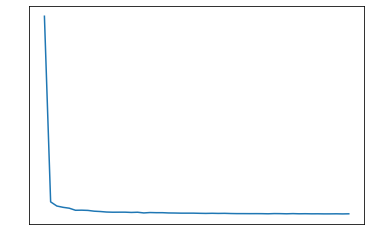

In [173]:
plt.plot(losses)

In [168]:
print(linear_output1.value.shape)
print(sigmoid_output1.value.shape)
print(linear_output2.value.shape)

(96, 64)
(96, 64)
(96, 64)


In [174]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import logging
import numpy as np
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [179]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(64,  activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(1,)
])

model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(0.01))#0.01步长

In [180]:
model.fit(X_, y_, epochs=500, batch_size=96)

Epoch 1/500
506/506 [==============================] - 1s 1ms/sample - loss: 502.9251
Epoch 2/500
506/506 [==============================] - 0s 65us/sample - loss: 325.2068
Epoch 3/500
506/506 [==============================] - 0s 57us/sample - loss: 238.2581
Epoch 4/500
506/506 [==============================] - 0s 53us/sample - loss: 181.6791
Epoch 5/500
506/506 [==============================] - 0s 42us/sample - loss: 142.2589
Epoch 6/500
506/506 [==============================] - 0s 40us/sample - loss: 115.2059
Epoch 7/500
506/506 [==============================] - 0s 57us/sample - loss: 97.8622
Epoch 8/500
506/506 [==============================] - 0s 55us/sample - loss: 85.6501
Epoch 9/500
506/506 [==============================] - 0s 47us/sample - loss: 75.4885
Epoch 10/500
506/506 [==============================] - 0s 49us/sample - loss: 68.5290
Epoch 11/500
506/506 [==============================] - 0s 45us/sample - loss: 64.5528
Epoch 12/500
506/506 [=========================

506/506 [==============================] - 0s 43us/sample - loss: 7.8674
Epoch 94/500
506/506 [==============================] - 0s 67us/sample - loss: 7.9813
Epoch 95/500
506/506 [==============================] - 0s 49us/sample - loss: 7.8595
Epoch 96/500
506/506 [==============================] - 0s 47us/sample - loss: 7.3910
Epoch 97/500
506/506 [==============================] - 0s 51us/sample - loss: 7.7433
Epoch 98/500
506/506 [==============================] - 0s 38us/sample - loss: 7.8936
Epoch 99/500
506/506 [==============================] - 0s 38us/sample - loss: 7.4276
Epoch 100/500
506/506 [==============================] - 0s 43us/sample - loss: 7.2933
Epoch 101/500
506/506 [==============================] - 0s 51us/sample - loss: 7.1383
Epoch 102/500
506/506 [==============================] - 0s 38us/sample - loss: 6.9114
Epoch 103/500
506/506 [==============================] - ETA: 0s - loss: 8.720 - 0s 43us/sample - loss: 6.9249
Epoch 104/500
506/506 [================

506/506 [==============================] - 0s 34us/sample - loss: 3.2510
Epoch 185/500
506/506 [==============================] - 0s 61us/sample - loss: 3.1782
Epoch 186/500
506/506 [==============================] - 0s 38us/sample - loss: 3.1999
Epoch 187/500
506/506 [==============================] - 0s 53us/sample - loss: 3.1482
Epoch 188/500
506/506 [==============================] - 0s 38us/sample - loss: 3.1560
Epoch 189/500
506/506 [==============================] - 0s 42us/sample - loss: 3.1672
Epoch 190/500
506/506 [==============================] - 0s 32us/sample - loss: 3.1090
Epoch 191/500
506/506 [==============================] - ETA: 0s - loss: 2.985 - 0s 51us/sample - loss: 3.0343
Epoch 192/500
506/506 [==============================] - ETA: 0s - loss: 3.742 - 0s 30us/sample - loss: 3.0880
Epoch 193/500
506/506 [==============================] - 0s 34us/sample - loss: 3.0279
Epoch 194/500
506/506 [==============================] - 0s 40us/sample - loss: 3.1448
Epoch 195

506/506 [==============================] - 0s 38us/sample - loss: 2.1912
Epoch 274/500
506/506 [==============================] - ETA: 0s - loss: 1.999 - 0s 71us/sample - loss: 2.1377
Epoch 275/500
506/506 [==============================] - 0s 38us/sample - loss: 2.1375
Epoch 276/500
506/506 [==============================] - ETA: 0s - loss: 2.327 - 0s 45us/sample - loss: 2.0985
Epoch 277/500
506/506 [==============================] - 0s 34us/sample - loss: 2.1007
Epoch 278/500
506/506 [==============================] - 0s 49us/sample - loss: 2.1282
Epoch 279/500
506/506 [==============================] - 0s 32us/sample - loss: 2.0491
Epoch 280/500
506/506 [==============================] - 0s 47us/sample - loss: 2.0286
Epoch 281/500
506/506 [==============================] - 0s 38us/sample - loss: 2.0172
Epoch 282/500
506/506 [==============================] - 0s 38us/sample - loss: 2.0446
Epoch 283/500
506/506 [==============================] - 0s 38us/sample - loss: 2.0473
Epoch 284

506/506 [==============================] - 0s 42us/sample - loss: 1.5197
Epoch 364/500
506/506 [==============================] - 0s 99us/sample - loss: 1.5652
Epoch 365/500
506/506 [==============================] - ETA: 0s - loss: 1.896 - 0s 67us/sample - loss: 1.5127
Epoch 366/500
506/506 [==============================] - 0s 40us/sample - loss: 1.5660
Epoch 367/500
506/506 [==============================] - 0s 47us/sample - loss: 1.5435
Epoch 368/500
506/506 [==============================] - 0s 55us/sample - loss: 1.5162
Epoch 369/500
506/506 [==============================] - 0s 42us/sample - loss: 1.5036
Epoch 370/500
506/506 [==============================] - 0s 61us/sample - loss: 1.5489
Epoch 371/500
506/506 [==============================] - 0s 55us/sample - loss: 1.5272
Epoch 372/500
506/506 [==============================] - 0s 40us/sample - loss: 1.5959
Epoch 373/500
506/506 [==============================] - 0s 42us/sample - loss: 1.5571
Epoch 374/500
506/506 [==========

506/506 [==============================] - 0s 30us/sample - loss: 1.1955
Epoch 455/500
506/506 [==============================] - 0s 45us/sample - loss: 1.1625
Epoch 456/500
506/506 [==============================] - 0s 49us/sample - loss: 1.1697
Epoch 457/500
506/506 [==============================] - 0s 55us/sample - loss: 1.1380
Epoch 458/500
506/506 [==============================] - 0s 53us/sample - loss: 1.1541
Epoch 459/500
506/506 [==============================] - 0s 53us/sample - loss: 1.2673
Epoch 460/500
506/506 [==============================] - ETA: 0s - loss: 1.086 - 0s 53us/sample - loss: 1.2671
Epoch 461/500
506/506 [==============================] - 0s 57us/sample - loss: 1.2216
Epoch 462/500
506/506 [==============================] - ETA: 0s - loss: 0.974 - 0s 59us/sample - loss: 1.1954
Epoch 463/500
506/506 [==============================] - 0s 43us/sample - loss: 1.1612
Epoch 464/500
506/506 [==============================] - ETA: 0s - loss: 0.681 - 0s 42us/sample 

大致一样的参数和数据在keras框架下训练得到loss和之前写的框架基本一致

---

# 思考
1. 以上从0实现的框架对于weight 和bias 的处理其实也把其看成了一个神经单元，而weight bias的数值存在该单元属性内。
2. 如果不把weight 和bias看作一个神经单元，而是把其数值存入到其所属layer的属性里面(相当于weight和bias的值是神经层的一个属性)，以此来建立的框架又和本次实现的框架有什么不同？其各自的优缺点又什么什么？
3. 可以把sigmoid函数在节点计算value的时候就植入，提供激活函数选择，或不选择，根据用户输入来决定。这样做就避免我们实际构建关系时在中间添加一个sigmoid节点层